This notebook is **almost** the same as 'Data-Munging-2.ipynb' except that I have dropped a few snippets that show data and the code to convert 'Total-time' to seconds is much easier.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
time_window = '3min' # This is the time window over which we will average call arrivals.
time_window_size = int(time_window[0])

In [49]:
ss = pd.read_csv('call-data.csv')

In [50]:
def was_abandoned(row):
    if pd.isnull(row['Abandon-time']):
        return False
    else:
        return True
    
ss['Abandoned'] = ss.apply(lambda r: was_abandoned(r), axis=1)

In [51]:
ss['Create time'] = pd.to_datetime(ss['Create time'], format='%m/%d/%Y %H:%M:%S', errors='ignore')
ss['Accept time'] = pd.to_datetime(ss['Accept time'], format='%m/%d/%Y %H:%M:%S', errors='ignore')
ss['Abandon-time'] = pd.to_datetime(ss['Abandon-time'], format='%m/%d/%Y %H:%M:%S', errors='ignore')
ss['Period'] = pd.to_datetime(ss['Period'], format='%m/%d/%Y', errors='ignore')

In [52]:
ss['Total-time'] = ss['Total-time'].apply(lambda x: pd.to_timedelta(x, errors='ignore'))

In [53]:
ss.loc[~ss['Total-time'].isnull()].head()

,Period,Media,Channel,Queue,Transaction,Origination,Customer,Case Number,Web Callback,Create time,...,Voice mail left,IVR-Treatment-Time,Hold-max,Hold-Count,Hold-Total,PDD-Leg1,PDD-Leg2,AT-Leg1,AT-Leg2,Abandoned
0,2020-11-23,Phone,441312855510,Customer Service Calls,311481,447723054957,NaN,NaN,NaN,2020-11-23 09:01:04,...,NaN,0:01:00,0:00:00,0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:04,False
1,2020-11-23,Phone,441312855510,Customer Service Calls,311505,447989913726,NaN,NaN,NaN,2020-11-23 09:01:38,...,NaN,0:01:00,0:00:00,0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:07,False
2,2020-11-23,Phone,441312855510,Customer Service Calls,311508,447775901409,NaN,NaN,NaN,2020-11-23 09:01:42,...,NaN,0:01:00,0:01:37,1,0:01:37,0:00:00,0:00:00,0:00:00,0:00:06,False
3,2020-11-23,Phone,441312855510,Customer Service Calls,311512,447917605569,NaN,NaN,NaN,2020-11-23 09:01:47,...,NaN,0:01:00,0:00:00,0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:05,False
4,2020-11-23,Phone,441312855510,Customer Service Calls,311517,441604494860,NaN,NaN,NaN,2020-11-23 09:01:50,...,NaN,0:01:00,0:00:00,0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:08,False


In [54]:
def calc_abandon_time(row):
    if row['Abandoned']:
        return row['Abandon-time'] - row['Create time']      
    else:
        return None

ss['Abandoned-after'] = ss[['Create time', 'Abandon-time', 'Abandoned']].apply(lambda r: calc_abandon_time(r), axis=1)

In [55]:
ss.rename(columns={'Create time': 'Create-time', 'Accept time': 'Accept-time'}, inplace=True)

In [56]:
attrs_of_interest = ['Period', 'Create-time', 'Agent', 'Accept-time', 'Total-time', 'Abandon-time', 'Abandoned', 'Abandoned-after']
data = ss.loc[:, attrs_of_interest]

In [57]:
data['time-to-accept'] = data.apply(lambda r: r['Accept-time'] - r['Create-time'], axis=1)

In [58]:
inflow = data[['Create-time', 'Agent']].groupby(pd.Grouper(key='Create-time', freq=time_window)).count()
inflow.reset_index(inplace=True)

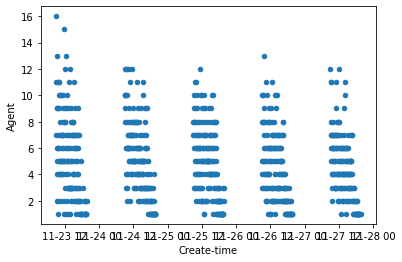

In [59]:
ignore = inflow.loc[inflow['Agent'] > 0].plot.scatter(x='Create-time', y='Agent')

In [60]:
inflow.iloc[inflow['Agent'].idxmax()]

Create-time    2020-11-23 09:03:00
Agent                           16
Name: 1, dtype: object

In [61]:
inflow.head()

,Create-time,Agent
0,2020-11-23 09:00:00,11
1,2020-11-23 09:03:00,16
2,2020-11-23 09:06:00,7
3,2020-11-23 09:09:00,13
4,2020-11-23 09:12:00,5


In [62]:
inflow.rename(columns = {'Agent': 'ncalls'}, inplace=True)

In [63]:
inflow.head()

,Create-time,ncalls
0,2020-11-23 09:00:00,11
1,2020-11-23 09:03:00,16
2,2020-11-23 09:06:00,7
3,2020-11-23 09:09:00,13
4,2020-11-23 09:12:00,5


In [64]:
inflow.to_csv('full-inflow-1.csv', index=False)

In [65]:
data['Total-time'] = data['Total-time'].apply(lambda r: r.seconds)
total_time = data[['Create-time', 'Total-time']].groupby(pd.Grouper(key='Create-time', freq=time_window)).mean()
total_time.reset_index(inplace=True)
total_time.rename(columns={'Total-time': 'Avg-time'}, inplace=True)
total_time.head()

,Create-time,Avg-time
0,2020-11-23 09:00:00,728.000000
1,2020-11-23 09:03:00,691.500000
2,2020-11-23 09:06:00,614.285714
3,2020-11-23 09:09:00,766.769231
4,2020-11-23 09:12:00,608.800000


In [66]:
total_time.loc[~total_time['Avg-time'].isnull()].head()

,Create-time,Avg-time
0,2020-11-23 09:00:00,728.000000
1,2020-11-23 09:03:00,691.500000
2,2020-11-23 09:06:00,614.285714
3,2020-11-23 09:09:00,766.769231
4,2020-11-23 09:12:00,608.800000


In [67]:
total_time.to_csv('total_time_1.csv', index=False)

In [68]:
consolidated = pd.merge(left=inflow, right=total_time, on='Create-time')

In [69]:
consolidated.head()

,Create-time,ncalls,Avg-time
0,2020-11-23 09:00:00,11,728.000000
1,2020-11-23 09:03:00,16,691.500000
2,2020-11-23 09:06:00,7,614.285714
3,2020-11-23 09:09:00,13,766.769231
4,2020-11-23 09:12:00,5,608.800000


In [70]:
def extract_period(dt):
    return str(dt)[0:10]    

consolidated['Period'] = consolidated.apply(lambda r: extract_period(r['Create-time']), axis=1)

In [71]:
nagents = ss[['Period', 'Agent']].groupby('Period').nunique()
nagents.reset_index(inplace=True)

In [82]:
nagents.head()

,Period,Agent
0,2020-11-23,52
1,2020-11-24,65
2,2020-11-25,66
3,2020-11-26,59
4,2020-11-27,50


In [76]:
nagents.dtypes

Period    datetime64[ns]
Agent              int64
dtype: object

In [77]:
consolidated.dtypes

Create-time    datetime64[ns]
ncalls                  int64
Avg-time              float64
Period                 object
dtype: object

In [80]:
def convert(d):
    yr = d.year
    mn = d.month
    dy = d.day
    
    return str(yr) + '-' + str(mn) + '-' + str(dy)

In [81]:
nagents['Period'] = nagents.apply(lambda r: convert(r['Period']), axis=1)

In [83]:
consolidated = pd.merge(left=consolidated, right=nagents, on='Period')

In [84]:
consolidated.rename(columns={'Agent': 'nagents'}, inplace=True)

In [85]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents
0,2020-11-23 09:00:00,11,728.000000,2020-11-23,52
1,2020-11-23 09:03:00,16,691.500000,2020-11-23,52
2,2020-11-23 09:06:00,7,614.285714,2020-11-23,52
3,2020-11-23 09:09:00,13,766.769231,2020-11-23,52
4,2020-11-23 09:12:00,5,608.800000,2020-11-23,52


In [86]:
consolidated.shape

(2132, 5)

In [87]:
consolidated.dtypes

Create-time    datetime64[ns]
ncalls                  int64
Avg-time              float64
Period                 object
nagents                 int64
dtype: object

In [88]:
import datetime

In [89]:
consolidated.iloc[0, :][0].time() > datetime.time(9, 0)

False

In [90]:
def is_office_hour(dt):
    return dt.time() > datetime.time(9, 0) and dt.time() < datetime.time(17, 1)

consolidated['office-hour'] = consolidated.apply(lambda r: is_office_hour(r['Create-time']), axis=1)

In [91]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents,office-hour
0,2020-11-23 09:00:00,11,728.000000,2020-11-23,52,False
1,2020-11-23 09:03:00,16,691.500000,2020-11-23,52,True
2,2020-11-23 09:06:00,7,614.285714,2020-11-23,52,True
3,2020-11-23 09:09:00,13,766.769231,2020-11-23,52,True
4,2020-11-23 09:12:00,5,608.800000,2020-11-23,52,True


In [92]:
consolidated['Avg-calls'] = consolidated['ncalls'].rolling(window=time_window_size).mean()

In [93]:
consolidated['iso_day_of_week'] = consolidated['Create-time'].apply(lambda r: r.isoweekday())

In [94]:
consolidated.head(10)

,Create-time,ncalls,Avg-time,Period,nagents,office-hour,Avg-calls,iso_day_of_week
0,2020-11-23 09:00:00,11,728.000000,2020-11-23,52,False,NaN,1
1,2020-11-23 09:03:00,16,691.500000,2020-11-23,52,True,NaN,1
2,2020-11-23 09:06:00,7,614.285714,2020-11-23,52,True,11.333333,1
3,2020-11-23 09:09:00,13,766.769231,2020-11-23,52,True,12.000000,1
4,2020-11-23 09:12:00,5,608.800000,2020-11-23,52,True,8.333333,1
5,2020-11-23 09:15:00,6,640.333333,2020-11-23,52,True,8.000000,1
6,2020-11-23 09:18:00,9,734.111111,2020-11-23,52,True,6.666667,1
7,2020-11-23 09:21:00,2,402.500000,2020-11-23,52,True,5.666667,1
8,2020-11-23 09:24:00,4,478.000000,2020-11-23,52,True,5.000000,1
9,2020-11-23 09:27:00,9,750.666667,2020-11-23,52,True,5.000000,1


In [95]:
C = consolidated[(consolidated['office-hour'] == True) & (consolidated['iso_day_of_week'] < 6)]

In [96]:
C.head(10)

,Create-time,ncalls,Avg-time,Period,nagents,office-hour,Avg-calls,iso_day_of_week
1,2020-11-23 09:03:00,16,691.500000,2020-11-23,52,True,NaN,1
2,2020-11-23 09:06:00,7,614.285714,2020-11-23,52,True,11.333333,1
3,2020-11-23 09:09:00,13,766.769231,2020-11-23,52,True,12.000000,1
4,2020-11-23 09:12:00,5,608.800000,2020-11-23,52,True,8.333333,1
5,2020-11-23 09:15:00,6,640.333333,2020-11-23,52,True,8.000000,1
6,2020-11-23 09:18:00,9,734.111111,2020-11-23,52,True,6.666667,1
7,2020-11-23 09:21:00,2,402.500000,2020-11-23,52,True,5.666667,1
8,2020-11-23 09:24:00,4,478.000000,2020-11-23,52,True,5.000000,1
9,2020-11-23 09:27:00,9,750.666667,2020-11-23,52,True,5.000000,1
10,2020-11-23 09:30:00,11,527.909091,2020-11-23,52,True,8.000000,1


In [97]:
C.to_csv('consolidated-1.csv', index=False)